In [ ]:
pip install plotly

In [1]:
import numpy as np
import pandas as pd
from pandas import plotting
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import sklearn.cluster as sklc
import sklearn.metrics as sklm
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy import stats
from scipy.stats import bartlett
import plotly.graph_objs as go
import plotly.offline as py

In [2]:
data = pd.read_csv('k8.csv')
print(data.columns.values)

['dbn' 'school_name' 'school_type' 'enrollment' 'survey_pp_RI'
 'survey_pp_CT' 'survey_pp_SE' 'survey_pp_ES' 'survey_pp_SF' 'suvey_pp_TR'
 'ELL' 'IEP' 'cap_sc_pct' 'eni_pct' 'temp_housing_pct' 'hra_elig_pct'
 'white' 'n_prof_pct_mth_all']


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dbn                 222 non-null    object 
 1   school_name         222 non-null    object 
 2   school_type         222 non-null    object 
 3   enrollment          222 non-null    int64  
 4   survey_pp_RI        222 non-null    float64
 5   survey_pp_CT        222 non-null    float64
 6   survey_pp_SE        222 non-null    float64
 7   survey_pp_ES        222 non-null    float64
 8   survey_pp_SF        222 non-null    float64
 9   suvey_pp_TR         222 non-null    float64
 10  ELL                 222 non-null    float64
 11  IEP                 222 non-null    float64
 12  cap_sc_pct          222 non-null    float64
 13  eni_pct             222 non-null    float64
 14  temp_housing_pct    222 non-null    float64
 15  hra_elig_pct        222 non-null    float64
 16  white   

In [4]:
data['MathLevelRate'] = data['n_prof_pct_mth_all']/data['enrollment']

In [5]:
data['OverallQuality'] = data[['survey_pp_RI','survey_pp_CT','survey_pp_SE','survey_pp_ES','survey_pp_SF','suvey_pp_TR']].mean(axis=1)

In [7]:
data = data[['dbn', 'school_name', 'school_type', 'enrollment', 
 'ELL', 'IEP', 'cap_sc_pct', 'eni_pct', 'temp_housing_pct', 'hra_elig_pct',
 'white', 'MathLevelRate','OverallQuality']]

In [8]:
data.describe()

,enrollment,ELL,IEP,cap_sc_pct,eni_pct,temp_housing_pct,hra_elig_pct,white,MathLevelRate,OverallQuality
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,666.126126,0.100761,0.196860,0.044477,0.633212,0.125450,0.483221,0.135185,0.633348,0.835863
std,283.109659,0.087869,0.077537,0.047454,0.215366,0.100247,0.196658,0.199060,0.071316,0.058106
min,135.000000,0.000000,0.033000,0.000000,0.099000,0.002000,0.027000,0.000000,0.304029,0.670000
25%,472.250000,0.034250,0.145000,0.006000,0.488250,0.046000,0.341000,0.009000,0.600443,0.798750
50%,643.000000,0.071500,0.190000,0.029000,0.696000,0.095000,0.523000,0.024000,0.637161,0.840833
75%,805.750000,0.145250,0.238750,0.066000,0.793750,0.185000,0.628000,0.214000,0.668037,0.875000
max,1750.000000,0.443000,0.593000,0.221000,0.938000,0.522000,0.808000,0.856000,0.976695,0.995000


## Z Score Transformation

In [14]:
col = ['ELL', 'IEP', 'cap_sc_pct', 'eni_pct', 'temp_housing_pct', 'hra_elig_pct',
 'white','MathLevelRate', 'OverallQuality']
features = data[col]
remains = data.drop(columns=col)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, index=data.index, columns=col)

In [15]:
pcre = pd.merge(remains, scaled_df, left_index=True, right_index=True, how='inner')
pcre = pcre.round(3)
pcre.describe()

,enrollment,ELL,IEP,cap_sc_pct,eni_pct,temp_housing_pct,hra_elig_pct,white,MathLevelRate,OverallQuality
count,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000,222.000000
mean,666.126126,0.000041,-0.000005,0.000005,-0.000018,0.000117,-0.000018,0.000045,-0.000018,0.000032
std,283.109659,1.002244,1.002281,1.002246,1.002253,1.002071,1.002257,1.002237,1.002277,1.002273
min,135.000000,-1.149000,-2.118000,-0.939000,-2.486000,-1.234000,-2.325000,-0.681000,-4.628000,-2.861000
25%,472.250000,-0.758250,-0.670000,-0.813000,-0.674500,-0.794000,-0.724750,-0.635000,-0.462250,-0.640000
50%,643.000000,-0.333500,-0.089000,-0.327000,0.292500,-0.304000,0.203000,-0.560000,0.053500,0.085500
75%,805.750000,0.507500,0.541750,0.455000,0.747000,0.595000,0.738000,0.396750,0.487500,0.675000
max,1750.000000,3.904000,5.121000,3.728000,1.418000,3.965000,1.655000,3.629000,4.825000,2.745000


## Pearson Correlation Coefficient

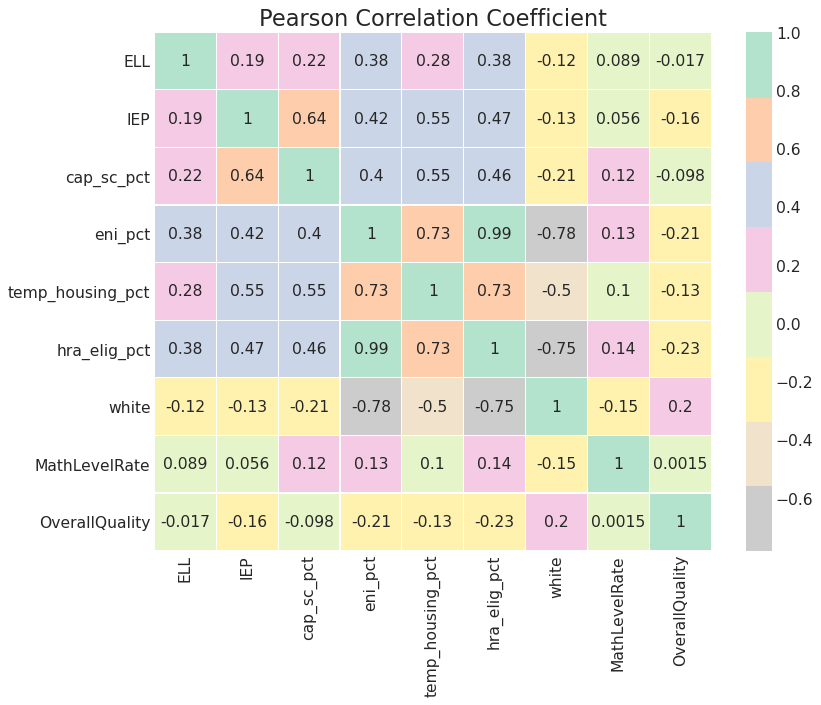

In [127]:
sns.set_style("whitegrid")
#plt.style.use()
corr_heatmap=scaled_df
x=corr_heatmap.corr(method='pearson')

plt.figure(figsize=(10,8), dpi= 80)
sns.heatmap(x,cmap='Pastel2_r',annot=True,linewidth=0.2)
plt.title('Pearson Correlation Coefficient')
plt.xticks(rotation=90)
plt.savefig('per.png')
#PiYG

In [16]:
pcre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222 entries, 0 to 221
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dbn               222 non-null    object 
 1   school_name       222 non-null    object 
 2   school_type       222 non-null    object 
 3   enrollment        222 non-null    int64  
 4   ELL               222 non-null    float64
 5   IEP               222 non-null    float64
 6   cap_sc_pct        222 non-null    float64
 7   eni_pct           222 non-null    float64
 8   temp_housing_pct  222 non-null    float64
 9   hra_elig_pct      222 non-null    float64
 10  white             222 non-null    float64
 11  MathLevelRate     222 non-null    float64
 12  OverallQuality    222 non-null    float64
dtypes: float64(9), int64(1), object(3)
memory usage: 22.7+ KB


## K-means

In [17]:
x = pcre.iloc[:, [10, 12, 11]].values

# let's check the shape of x
print(x.shape)

(222, 3)


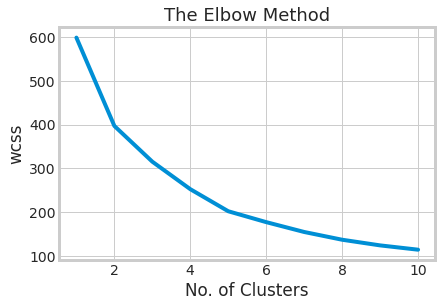

<Figure size 720x576 with 0 Axes>

In [14]:
sns.set_style("whitegrid")


wcss = []
for i in range(1, 11):
    km = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    km.fit(x)
    wcss.append(km.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 18)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.figure(figsize=(10,8))
plt.savefig('elbow')

In [19]:
kmeans = KMeans(n_clusters=5)

y = kmeans.fit_predict(pcre[['white', 'OverallQuality', 'MathLevelRate']])

pcre['Cluster'] = y

print(pcre.head())

      dbn                                        school_name school_type  \
0  01M034                     P.S. 034 Franklin D. Roosevelt         K-8   
1  01M140                             P.S. 140 Nathan Straus         K-8   
2  01M184                               P.S. 184m Shuang Wen         K-8   
3  01M188                         P.S. 188 The Island School         K-8   
4  01M539  New Explorations into Science, Technology and ...         K-8   

   enrollment    ELL    IEP  cap_sc_pct  eni_pct  temp_housing_pct  \
0         337 -0.237  2.367      -0.496    1.111             1.595   
1         364  0.265  1.824       1.912    1.023             0.615   
2         636  0.801 -0.063      -0.897   -0.341            -0.234   
3         416  0.607  1.747       0.581    1.418             3.965   
4        1131 -1.104 -2.015      -0.939   -2.170            -1.184   

   hra_elig_pct  white  MathLevelRate  OverallQuality  Cluster  
0         0.988 -0.530          0.774          -1.337    

## Clusters 

In [20]:
result2 = pcre.groupby('Cluster')[col].agg('median')
result2

,ELL,IEP,cap_sc_pct,eni_pct,temp_housing_pct,hra_elig_pct,white,MathLevelRate,OverallQuality
Cluster,,,,,,,,,
0,-0.864,1.9150,-0.0100,-0.080,-0.644,0.0290,-0.0610,4.7780,0.330
1,-0.305,-0.1275,-0.3900,0.397,-0.239,0.2515,-0.5950,0.1390,0.618
2,-0.214,0.0920,-0.1580,0.646,0.215,0.6160,-0.6200,0.1570,-0.762
3,-0.476,0.0150,-0.6860,-0.180,-0.679,-0.3655,0.2885,-2.0985,-0.015
4,-0.528,-0.2500,-0.2745,-1.418,-0.969,-1.4180,1.5875,-0.0615,0.503


In [ ]:
result = pcre.groupby('Cluster')['dbn'].agg('count')

In [56]:
result.head()

Cluster
0    13
1    84
2    42
3     3
4    80
Name: dbn, dtype: int64

In [31]:
x = pcre[['white', 'OverallQuality', 'MathLevelRate']].values
km = KMeans(n_clusters = 5, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
km.fit(x)
labels = km.labels_
centroids = km.cluster_centers_

In [34]:
kdf = pcre[['white', 'OverallQuality', 'MathLevelRate']]

## Silhouette Score

.............
Largest silhouette score was 0.4233 for k=2


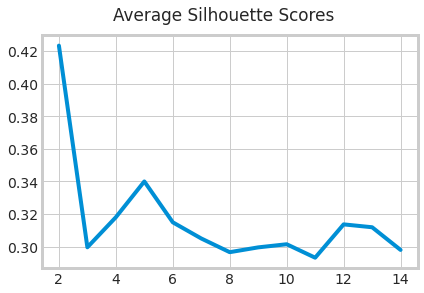

In [42]:
sns.set_style("whitegrid")
x = []
y = []

for k in range(2,15):

    kmeans = KMeans(n_clusters=k, n_init=25, random_state=42).fit(kdf)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(kdf, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.gcf().suptitle("Average Silhouette Scores");

In [38]:
# SILHOUETTE SCORE

# These lines calculate the silhouette score...
silhouette_kmeans = sklm.silhouette_score(pcre[['white', 'OverallQuality', 'MathLevelRate']],labels)

# ... and print it:
print("Silhouette Score:", silhouette_kmeans)

Silhouette Score: 0.33995496043676465


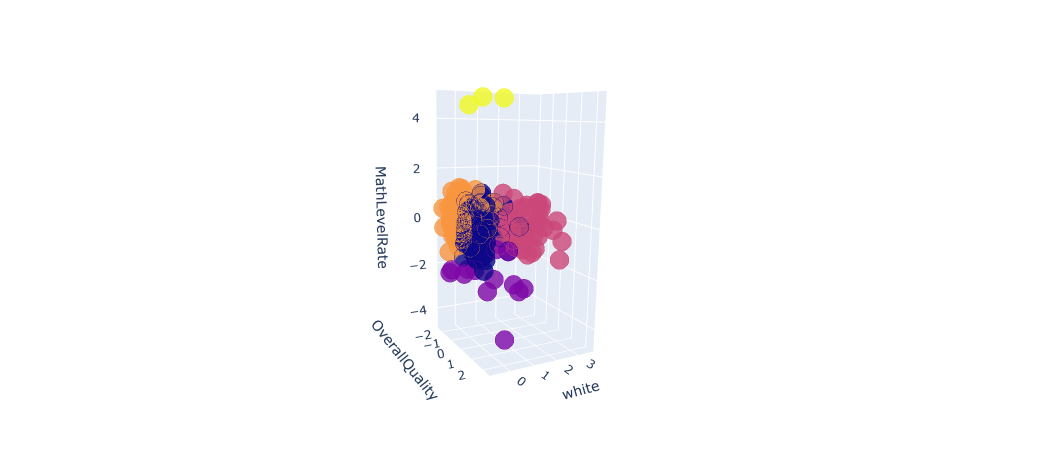

In [43]:
pcre['labels'] =  labels
trace1 = go.Scatter3d(
    x= pcre['OverallQuality'],
    y= pcre['white'],
    z= pcre['MathLevelRate'],
    mode='markers',
     marker=dict(
        color = pcre['labels'], 
        size= 10,
        line=dict(
            color= pcre['labels'],
            width= 12
        ),
        opacity=0.8
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Character vs Gender vs Alive or not',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'OverallQuality'),
            yaxis = dict(title  = 'white'),
            zaxis = dict(title  = 'MathLevelRate')
        )
)

fig = go.Figure(data=df, layout = layout)
py.iplot(fig)

<AxesSubplot:title={'center':'eni_pct'}, xlabel='Cluster'>

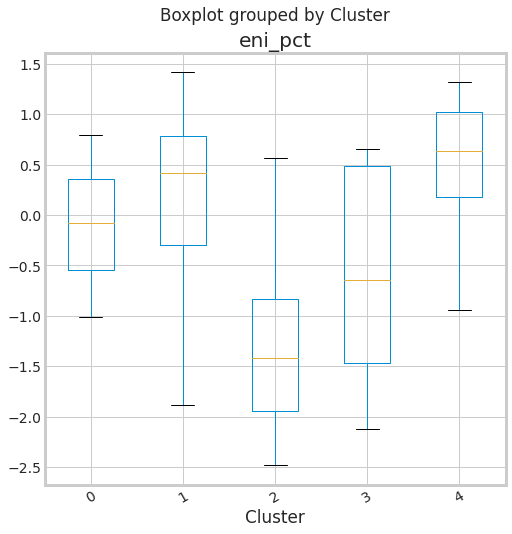

In [55]:
sns.set_style("whitegrid")
pcre.boxplot('eni_pct','Cluster',rot = 30,figsize=(8, 8))

In [118]:
final = pd.merge(data, pcre, left_on='dbn', right_on='dbn').set_index('Cluster')

In [119]:
cluster0 = final.loc[final.index.isin([0])]
cluster1 = final.loc[final.index.isin([1])]
cluster2 = final.loc[final.index.isin([2])]
cluster3 = final.loc[final.index.isin([3])]
cluster4 = final.loc[final.index.isin([4])]

## Normalisation

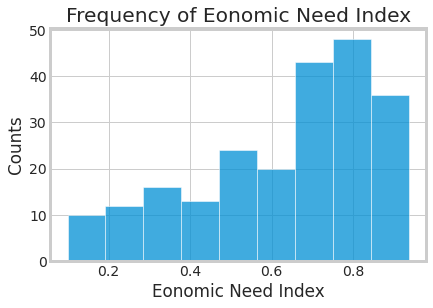

In [52]:
#sns.histplot(x=pcre['Raised_power_value'])
ax = sns.histplot(x=data['eni_pct'])
ax.set(xlabel= 'Eonomic Need Index', ylabel='Counts', title='Frequency of Eonomic Need Index')
plt.show()

In [76]:
from scipy.stats import boxcox
import pylab

In [56]:
skwed_dist = data['eni_pct']

In [ ]:
skewed_box_cox, lmda = stats.boxcox(skwed_dist)

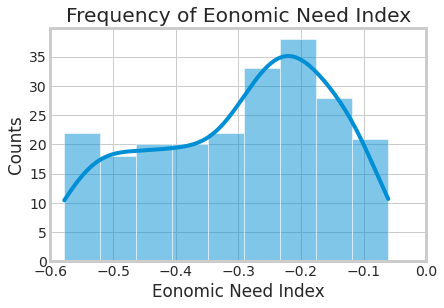

In [73]:
ax = sns.histplot(x=skewed_box_cox, kde=True)
ax.set(xlabel= 'Eonomic Need Index', ylabel='Counts', title='Frequency of Eonomic Need Index', xlim=[-0.6,0])
plt.show()

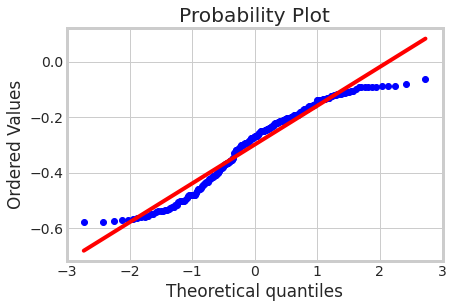

lambda parameter for Box-Cox Transformation is: 1.6959627608315422


In [77]:
stats.probplot(skewed_box_cox, dist='norm', plot=pylab)
pylab.show()
print ("lambda parameter for Box-Cox Transformation is:",lmda)

### can be fully nomalised, so could not apply ANOVA

## Try Kruskal-Wallis

In [126]:
ctrl = cluster0['eni_pct_x']
trt1 = cluster1['eni_pct_x']
trt2 = cluster2['eni_pct_x']
ss23 = cluster3['eni_pct_x']
sser = cluster4['eni_pct_x']
stats.kruskal(ctrl, trt1, trt2, ss23, sser)

KruskalResult(statistic=83.75528501009484, pvalue=2.7861329980424607e-17)